In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import glob

sns.set(style="whitegrid")
data_path = "./results"


# this function loads all the csv files into a single dataframe
def load_csv_files(path):
    all_files = glob.glob(f"{path}/*.csv")

    df_list = [pd.read_csv(f) for f in all_files]
    return pd.concat(df_list, ignore_index=True)

df = load_csv_files(data_path)

# Clean and preprocess data
df['Time Spent (s)'] = pd.to_numeric(df['Time Spent (s)'], errors='coerce')
df['IsCorrect'] = df['Correct'].apply(lambda x: x == 'Correct')
df = df.dropna(subset=['Type', 'Time Spent (s)'])



In [10]:
# This function calculates the average time spent by naming convention type and correctness
def calculate_statistics(df):
    avg_time_by_type = df.groupby('Type', as_index=False)['Time Spent (s)'].mean()
    avg_time_by_correctness = df.groupby('IsCorrect', as_index=False)['Time Spent (s)'].mean()
    error_rate = df.groupby('Type', as_index=False).agg({'IsCorrect': lambda x: 1 - x.mean()})
    error_rate.rename(columns={'IsCorrect': 'Error Rate'}, inplace=True)
    return avg_time_by_type, avg_time_by_correctness, error_rate


# Summarize the data by printing the total attempts, correct attempts, and success rate
def summarize_data(df, avg_time_by_type):
    total_attempts = len(df)
    correct_attempts = df['IsCorrect'].sum()
    success_rate = correct_attempts / total_attempts
    print("Summary Statistics:")
    print("\nAverage Time by Type:")
    print(avg_time_by_type)
    print(f"\nTotal Attempts: {total_attempts}")
    print(f"Correct Attempts: {correct_attempts}")
    print(f"Success Rate: {success_rate:.2%}")


# Calculate statistics
avg_time_by_type, avg_time_by_correctness, error_rate = calculate_statistics(df)

summarize_data(df, avg_time_by_type)

Summary Statistics:

Average Time by Type:
         Type  Time Spent (s)
0   camelCase        3.747713
1  kebab-case        3.012019

Total Attempts: 216
Correct Attempts: 192
Success Rate: 88.89%


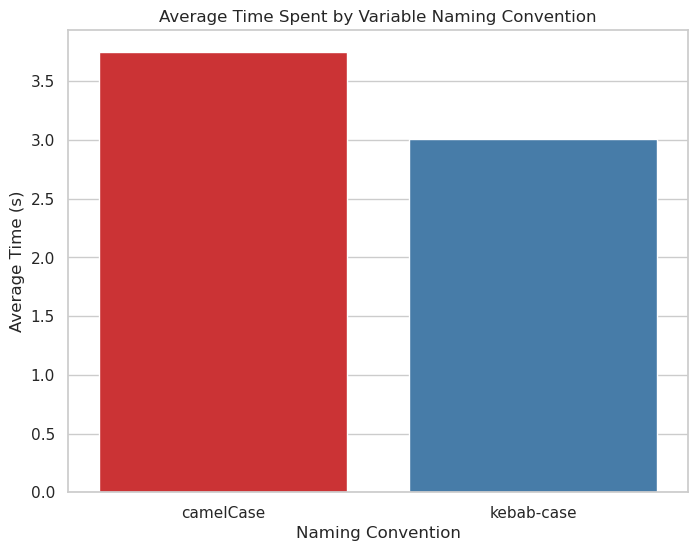

In [11]:
# This function plots the average time spent by variable naming convention type
def plot_average_time_by_type(avg_time_by_type):
    plt.figure(figsize=(8, 6))
    sns.barplot(data=avg_time_by_type, x='Type', y='Time Spent (s)', hue='Type', palette='Set1', legend=False)
    plt.title('Average Time Spent by Variable Naming Convention')
    plt.ylabel('Average Time (s)')
    plt.xlabel('Naming Convention')
    plt.show()

plot_average_time_by_type(avg_time_by_type)

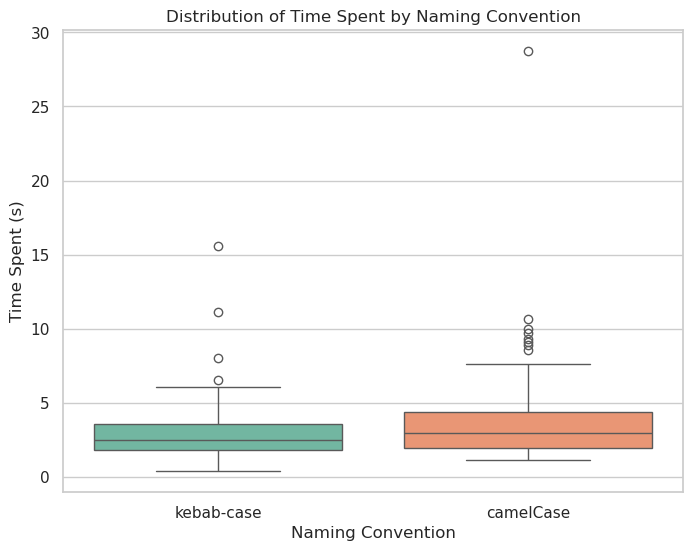

In [12]:
# This function plots the distribution of time spent by naming convention type
def plot_time_distribution_by_type(df):
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df, x='Type', y='Time Spent (s)', hue='Type', palette='Set2', legend=False)
    plt.title('Distribution of Time Spent by Naming Convention')
    plt.xlabel('Naming Convention')
    plt.ylabel('Time Spent (s)')
    plt.show()

plot_time_distribution_by_type(df)

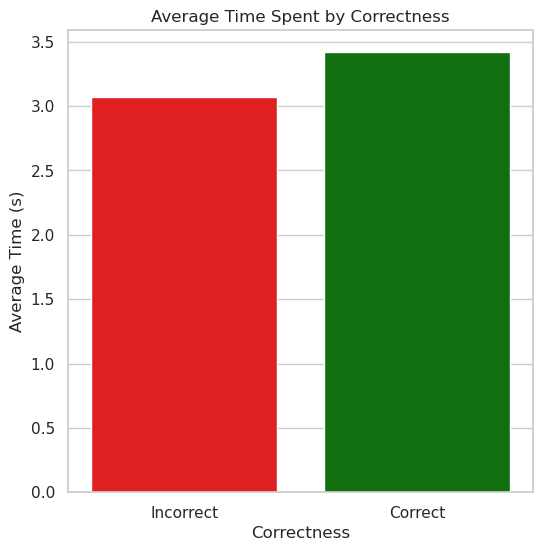

In [13]:
# It plots the average time spent both for correct and incorrect attempts
def plot_average_time_by_correctness(avg_time_by_correctness):
    plt.figure(figsize=(6, 6))
    sns.barplot(data=avg_time_by_correctness, x='IsCorrect', y='Time Spent (s)', hue='IsCorrect', dodge=False, palette={True: 'green', False: 'red'}, legend=False)
    plt.title('Average Time Spent by Correctness')
    plt.xticks([0, 1], ['Incorrect', 'Correct'])
    plt.ylabel('Average Time (s)')
    plt.xlabel('Correctness')
    plt.show()

plot_average_time_by_correctness(avg_time_by_correctness)

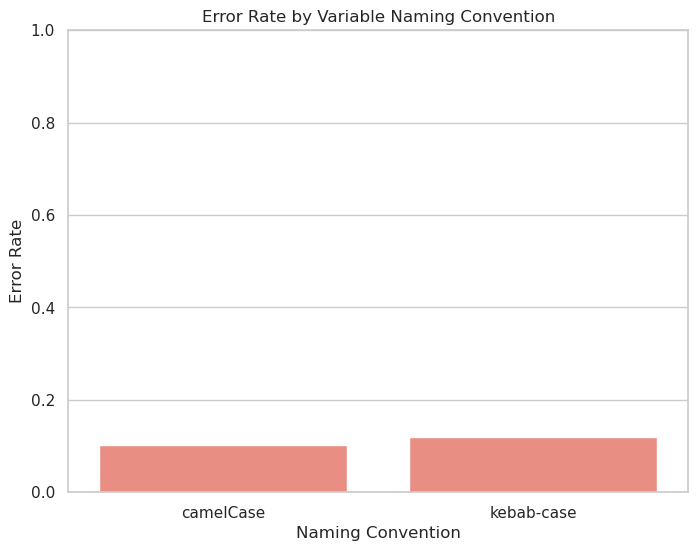

In [14]:
# It plots the error rate by naming convention type
def plot_error_rate_by_type(error_rate):
    plt.figure(figsize=(8, 6))
    sns.barplot(data=error_rate, x='Type', y='Error Rate', color='salmon')
    plt.title('Error Rate by Variable Naming Convention')
    plt.ylabel('Error Rate')
    plt.xlabel('Naming Convention')
    plt.ylim(0, 1)
    plt.show()

plot_error_rate_by_type(error_rate)

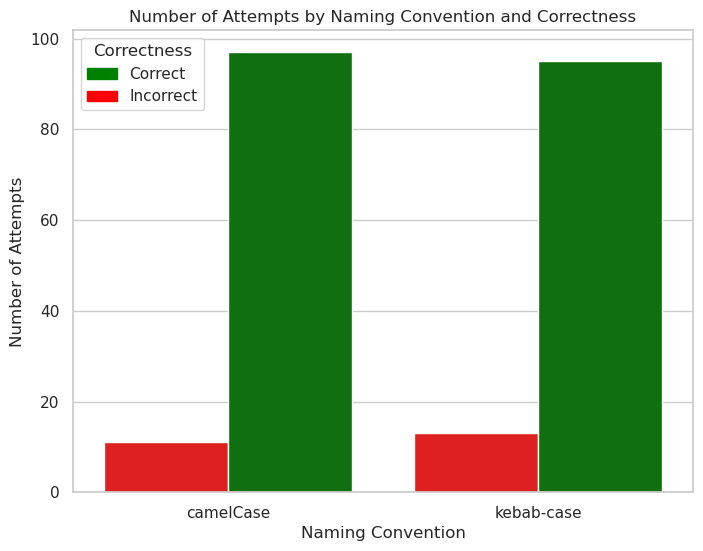

In [15]:
# It plots the number of attempts by naming convention and correctness
def plot_correctness_by_type(df):
    count_data = df.groupby(['Type', 'IsCorrect'], as_index=False).size().rename(columns={'size': 'Count'})
    plt.figure(figsize=(8, 6))
    sns.barplot(data=count_data, x='Type', y='Count', hue='IsCorrect', palette={True: 'green', False: 'red'})
    plt.title('Number of Attempts by Naming Convention and Correctness')
    plt.xlabel('Naming Convention')
    plt.ylabel('Number of Attempts')

    correct_patch = mpatches.Patch(color='green', label='Correct')
    incorrect_patch = mpatches.Patch(color='red', label='Incorrect')
    plt.legend(handles=[correct_patch, incorrect_patch], title='Correctness')
    plt.show()

plot_correctness_by_type(df)


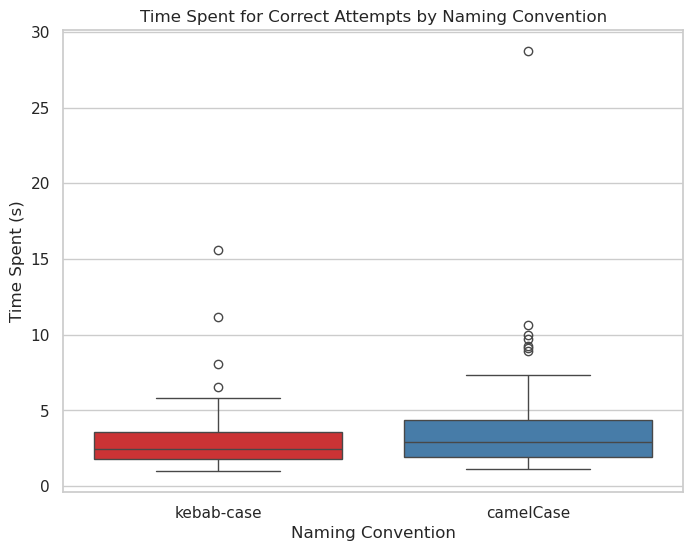

In [16]:
# It plots the time only for correct attempts by naming convention type
def plot_time_correct_attempts_by_type(df):
    correct_attempts = df[df['IsCorrect']]
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=correct_attempts, x='Type', y='Time Spent (s)', hue='Type', palette='Set1', legend=False)
    plt.title('Time Spent for Correct Attempts by Naming Convention')
    plt.xlabel('Naming Convention')
    plt.ylabel('Time Spent (s)')
    plt.show()

plot_time_correct_attempts_by_type(df)